# Model training

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

In [ ]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

* We support Llama, Mistral, CodeLlama, TinyLlama, Vicuna, Open Hermes etc
* And Yi, Qwen ([llamafied](https://huggingface.co/models?sort=trending&search=qwen+llama)), Deepseek, all Llama, Mistral derived archs.
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.
* [**NEW**] We make Gemma 6 trillion tokens **2.5x faster**! See our [Gemma notebook](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)
* [**NEW**] We make Llama-3 15 trillion tokens **2x faster**! See our [Llama-3 notebook](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing)

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 20000 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/llama-2-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    "unsloth/tinyllama-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit", # New Google 6 trillion tokens model 2.5x faster!
    "unsloth/gemma-2b-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-v0.3", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.11.11 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `ChatML` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing).

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [105]:
import json
import os
from datasets import Dataset


directory_path = '../syntax-semantics/Exp/datasets/'

examples = []

for filename in os.listdir(directory_path):
    if filename.endswith('.jsonl') and "NUM100" in filename:
        # print(filename)
        # continue
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                examples.append(json.loads(line))

del examples[6100:6200]

dataset = Dataset.from_list(examples)
dataset

Dataset({
    features: ['problem', 'solution_code', 'solution_wocode', 'result', 'template_name', 'idx'],
    num_rows: 9900
})

In [132]:
gsm_prompt = """
Instruction:
Below is a math question. Think through this question carefully and write a step-by-step response that appropriately answer this question. Please provide the final answer after ####.

Question:
{}

Solution:
{} 
#### {}
"""


EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    problems = examples["problem"]
    outputs = examples["solution_wocode"]
    answers = examples["result"]
    texts = []
    for problem, output, answer in zip(problems, outputs, answers):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = gsm_prompt.format(problem, output, answer).strip() + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

dataset = dataset.map(formatting_prompts_func, batched = True,)
print(dataset[0]['text'])

Map: 100%|██████████| 9900/9900 [00:00<00:00, 151377.52 examples/s]

Instruction:
Below is a math question. Think through this question carefully and write a step-by-step response that appropriately answer this question. Please provide the final answer after ####.

Question:
A a yoga studio boutique makes a third of its sales in the air fryers section, a quarter of its sales in the jewelry section, and the rest in the stationery section. They made 12 sales today. How many sales were in the stationery section?

Solution:
The a yoga studio boutique made 12 / 3 = 4 sales in the air fryers section. It made 12 / 4 = 3 sales in the jewelry section. Thus, there were 12 - 4 - 3 = 5 sales in the stationery section. 
#### 5.0</s>


In [5]:
print(torch.cuda.get_device_name())
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

NameError: name 'torch' is not defined

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60, # Set num_train_epochs = 1 for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2): 100%|██████████| 9900/9900 [00:02<00:00, 3943.48 examples/s]
max_steps is given, it will override any value given in num_train_epochs


In [113]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100 80GB PCIe. Max memory = 79.254 GB.
14.162 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

In [7]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

87.51 seconds used for training.
1.46 minutes used for training.
Peak reserved memory = 5.201 GB.
Peak reserved memory for training = 0.681 GB.
Peak reserved memory % of max memory = 6.562 %.
Peak reserved memory for training % of max memory = 0.859 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [1]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

NameError: name 'FastLanguageModel' is not defined

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [9]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [10]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.model',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [176]:
!pwd

/home/zxl240011/RLHF/SFT


# Model evaluation

In [1]:
# Load GSM8K dataset

import json
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

directory_path = '../syntax-semantics/Exp/datasets/'
testdata = []

for filename in os.listdir(directory_path):
    if "NUM10.jsonl" in filename:
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                testdata.append(json.loads(line))

testdata[0]



{'problem': 'Rosy Plascencia sold 238 air fryers to her friends in April at a yoga studio boutique in Bracken County, Kentucky. In May, they sold 119 air fryers. How many air fryers did Rosy Plascencia sell altogether in April and May?',
 'solution_code': '# Number of air fryers sold by Rosy Plascencia in April\nair_fryers_in_April = 238\n\n# Number of air fryers sold by Rosy Plascencia in May\nair_fryers_in_May = air_fryers_in_April * 0.5\n\n# Calculating the total number of air fryers sold in April and May\ntotal_air_fryers = air_fryers_in_April + air_fryers_in_May\n\nresult = total_air_fryers\n',
 'solution_wocode': 'Rosy Plascencia sold 238 air fryers in April at a yoga studio boutique in Bracken County, Kentucky. In May, they sold 119 air fryers. In total, Rosy Plascencia sold 238 + 119 = 357.0 air fryers altogether in April and May.',
 'result': '357.0',
 'template_name': 'gsm-0000-1',
 'idx': 0}

In [2]:
gsm_prmpts = []
for data in testdata:
    prompt = \
f"""
Instruction:
Below is a math question. Think through this question carefully and write a step-by-step response that appropriately answer this question. Please provide the final answer after ####.

Question:
{data['problem']}
"""
    gsm_prmpts.append(prompt.strip())


In [3]:
# inputs = tokenizer(gsm_prmpts[:10], return_tensors = "pt", padding=True, truncation=True).to("cuda")
# outputs = model.generate(**inputs, max_new_tokens=500, use_cache=True)
# print(tokenizer.batch_decode(outputs, skip_special_tokens=True)[6])

In [ ]:
from unsloth import FastLanguageModel
max_seq_length = 20000 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Mistral_finetuned", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference


In [31]:
answers = []
for i in range(len(gsm_prmpts)):
    inputs = tokenizer(gsm_prmpts[i], return_tensors="pt", padding=True, truncation=True).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 250, use_cache = True)
    answer = tokenizer.batch_decode(outputs)[0]
    answers.append(answer)
    if abs(extract_numbers(answer) - float(testdata[i]['result'])) > 1e-3:
        print(answer)
        print('-'*50)
        print(float(testdata[i]['result']))
        print(extract_numbers(answer))
        # break


<s> Instruction:
Below is a math question. Think through this question carefully and write a step-by-step response that appropriately answer this question. Please provide the final answer after ####.

Question:
Rosy Plascencia is saving money for a new air fryers which costs $27800. Rosy Plascencia has only 25% of the money needed. Their parents decided to give them $180 for that purpose, and their grandparents twice as much as their parents. How much more money does Rosy Plascencia need to buy the air fryers?

Solution:
Rosy Plascencia has 25% of the money needed for the new air fryers which is $27800 * 25% = $6950. Their parents gave them $180 and their grandparents gave them 2 * $180 = $360. So Rosy Plascencia has a total amount of money of $6950 + $180 + $360 = $7490. They still need $27800 - $7490 = $19910 to buy the air fryers. 
#### 19910</s>
--------------------------------------------------
20310.0
19910.0
<s> Instruction:
Below is a math question. Think through this question 

In [32]:
len(answers)

1000

In [ ]:
import pickle

# Load the list from the file
# with open('./results/mistral_answers.pkl', 'wb') as file:
#     pickle.dump(answers, file)

# print(answer)


# # Load the list from the file
with open('./results/mistral_answers.pkl', 'rb') as file:
    answers = pickle.load(file)

len(answers)

1000

In [ ]:
inputs = tokenizer(gsm_prmpts[:500], return_tensors = "pt", padding=True, truncation=True).to("cuda")
outputs = model.generate(**inputs, max_new_tokens=500, use_cache=True)
answers1 = tokenizer.batch_decode(outputs, skip_special_tokens=True)


In [ ]:
inputs = tokenizer(gsm_prmpts[500:], return_tensors = "pt", padding=True, truncation=True).to("cuda")
outputs = model.generate(**inputs, max_new_tokens=700, use_cache=True)
answers2 = tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [70]:
testdata[11]

{'problem': 'Kendall Umana earns $79 per hour for working at an art gallery in Wood County, Texas. Yesterday, Kendall Umana worked for 2 hours. How much did Kendall Umana earn?',
 'solution_code': '# Earnings per hour for Kendall Umana\nearnings_per_hour_Kendall_Umana = 79\n\n# Number of hours worked by Kendall Umana\nhours_worked_Kendall_Umana = 2\n\n# Calculating the total earnings by multiplying the rate per hour by the number of hours worked\ntotal_earnings_Kendall_Umana = earnings_per_hour_Kendall_Umana * hours_worked_Kendall_Umana\n\nresult = total_earnings_Kendall_Umana\n',
 'solution_wocode': 'Kendall Umana earns $79 per hour for working at an art gallery in Wood County, Texas. Yesterday, Kendall Umana worked for 2 hours. Kendall Umana earned $79 x 2 = $158.',
 'result': '158',
 'template_name': 'gsm-0000-1',
 'idx': 1}

In [13]:
import re

def extract_numbers(raw_answer):
    if "####" in raw_answer:
        match = raw_answer.split("####")[-1]
        numbers = re.findall(r'-?\d+(?:,\d{3})*(?:\.\d+)?', match)
        if numbers:
            return float([num.replace(',', '') for num in numbers][-1])
    return 0


def evaluate_predictions(predictions, ground_truth):
    """
    Calculate accuracy of predictions.
    
    Args:
        predictions (list): Model predictions
        ground_truth (list): Correct answers
    
    Returns:
        float: Accuracy score
    """
    correct = sum(1 for p, g in zip(predictions, ground_truth) if abs(p - g) < 1e-1)
    return correct / len(predictions) if predictions else 0

In [ ]:
predictions = [extract_numbers(raw_answer) for raw_answer in answers]

In [ ]:
[*zip(ground_truth, predictions)]

In [18]:
i=-0
for a, b in [*zip(ground_truth, predictions)]:
    if abs(a-b) < 1:
        i += 1

print(i)

164


In [33]:
predictions = [extract_numbers(raw_answer) for raw_answer in answers]
ground_truth = [float(example["result"]) for example in testdata[:500]]

accuracy = evaluate_predictions(predictions, ground_truth)
accuracy

0.146

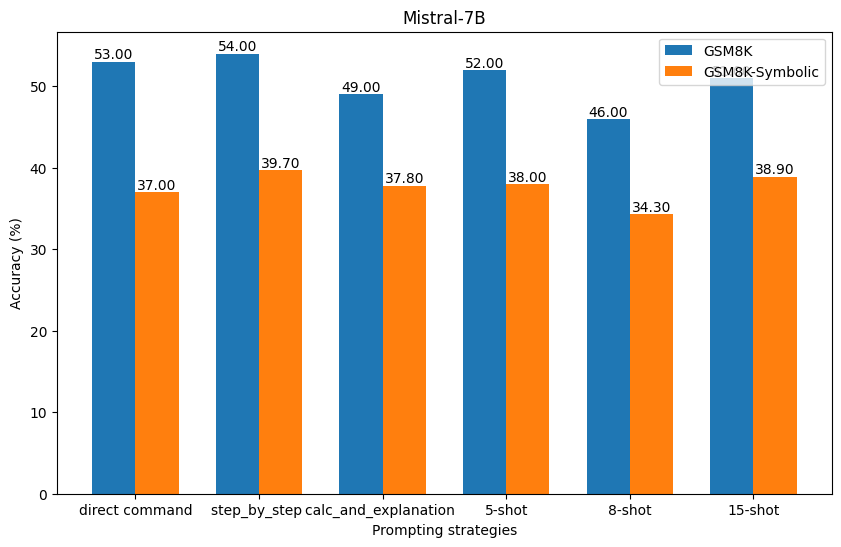

In [1]:
import matplotlib.pyplot as plt

# Mistral
x = ["direct command", "step_by_step ", "calc_and_explanation ", "5-shot", "8-shot", "15-shot"]
y1 = [53, 54, 49, 52, 46, 51]
y2 = [37, 39.7, 37.8, 38.0, 34.3, 38.9]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(x))

bar1 = plt.bar(index, y1, bar_width, label='GSM8K')
bar2 = plt.bar([i + bar_width for i in index], y2, bar_width, label='GSM8K-Symbolic')

# Adding labels and title
plt.xlabel('Prompting strategies')
plt.ylabel('Accuracy (%)')
plt.title('Mistral-7B')
plt.xticks([i + bar_width / 2 for i in index], x)
plt.legend()

# Displaying the values on the bars
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()

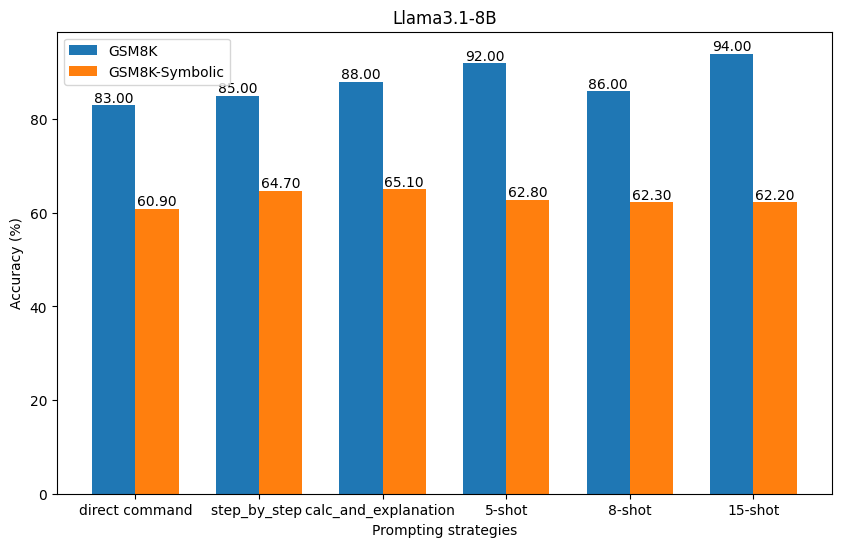

In [1]:
import matplotlib.pyplot as plt

# Mistral
x = ["direct command", "step_by_step ", "calc_and_explanation ", "5-shot", "8-shot", "15-shot"]
y1 = [83, 85, 88, 92, 86, 94]
y2 = [60.9, 64.7, 65.1, 62.8, 62.3, 62.2]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(x))

bar1 = plt.bar(index, y1, bar_width, label='GSM8K')
bar2 = plt.bar([i + bar_width for i in index], y2, bar_width, label='GSM8K-Symbolic')

# Adding labels and title
plt.xlabel('Prompting strategies')
plt.ylabel('Accuracy (%)')
plt.title('Llama3.1-8B')
plt.xticks([i + bar_width / 2 for i in index], x)
plt.legend()

# Displaying the values on the bars
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()

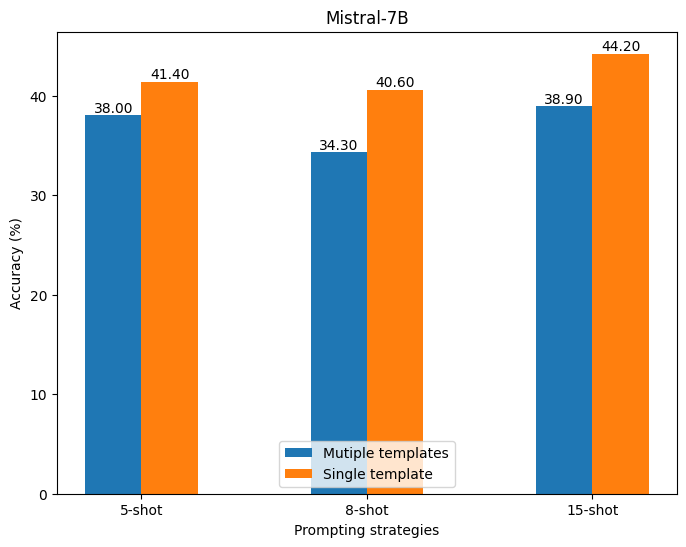

In [6]:
import matplotlib.pyplot as plt

# Mistral
x = ["5-shot", "8-shot", "15-shot"]
# y1 = [83, 85, 88, 92, 86, 94]
y1 = [38.0, 34.3, 38.9]
y2 = [41.4, 40.6, 44.2]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.25
index = range(len(x))

bar1 = plt.bar(index, y1, bar_width, label='Mutiple templates')
bar2 = plt.bar([i + bar_width for i in index], y2, bar_width, label='Single template')

# Adding labels and title
plt.xlabel('Prompting strategies')
plt.ylabel('Accuracy (%)')
plt.title('Mistral-7B')
plt.xticks([i + bar_width / 2 for i in index], x)
plt.legend(loc='lower center')

# Displaying the values on the bars
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()

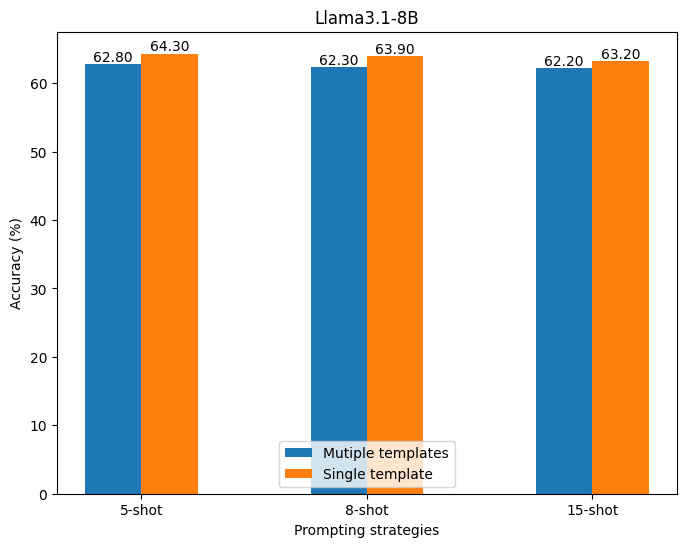

In [9]:
import matplotlib.pyplot as plt

# Mistral
x = ["5-shot", "8-shot", "15-shot"]
# y1 = [83, 85, 88, 92, 86, 94]
y1 = [62.80, 62.30, 62.20]
y2 = [64.30, 63.90, 63.20]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.25
index = range(len(x))

bar1 = plt.bar(index, y1, bar_width, label='Mutiple templates')
bar2 = plt.bar([i + bar_width for i in index], y2, bar_width, label='Single template')

# Adding labels and title
plt.xlabel('Prompting strategies')
plt.ylabel('Accuracy (%)')
plt.title('Llama3.1-8B')
plt.xticks([i + bar_width / 2 for i in index], x)
plt.legend(loc='lower center')

# Displaying the values on the bars
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()

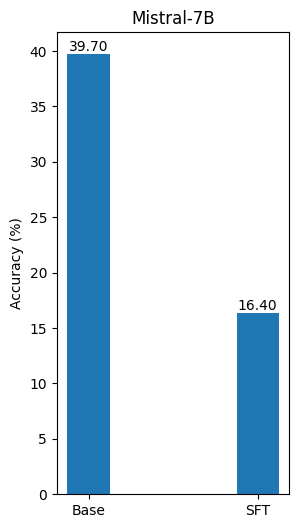

In [91]:
import matplotlib.pyplot as plt

# Mistral
x = ["Base","SFT"]
y1 = [39.7, 16.4]
# y2 = [64.3, 63.9, 63.2]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(3, 6))
bar_width = 0.25
index = range(len(x))

bar1 = plt.bar(index, y1, bar_width, )

# Adding labels and title
# plt.xlabel('Prompting strategies')
plt.ylabel('Accuracy (%)')
plt.title('Mistral-7B')
plt.xticks([i  for i in index], x)
# plt.legend(loc='lower center')

# Displaying the values on the bars
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()

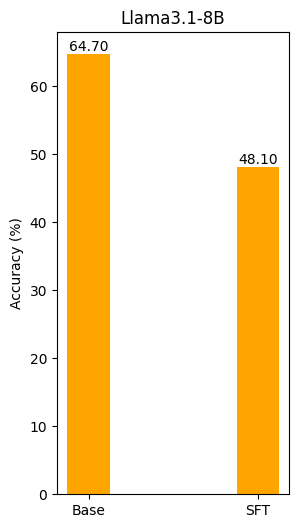

In [99]:
import matplotlib.pyplot as plt

# Mistral
x = ["Base","SFT"]
y1 = [64.7, 48.1]
# y2 = [64.3, 63.9, 63.2]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(3, 6))
bar_width = 0.25
index = range(len(x))

bar1 = plt.bar(index, y1, bar_width, color='orange')

# Adding labels and title
# plt.xlabel('Prompting strategies')
plt.ylabel('Accuracy (%)')
plt.title('Llama3.1-8B')
plt.xticks([i  for i in index], x)
# plt.legend(loc='lower center')

# Displaying the values on the bars
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()

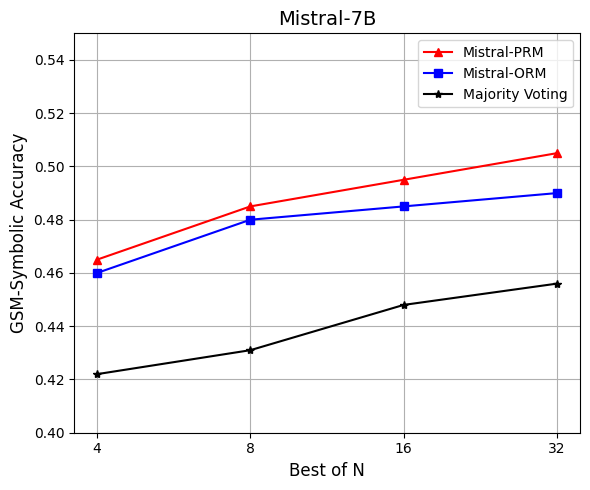

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
x = ["4", "8", "16", "32",]

mistral_prm = [0.465, 0.485, 0.495, 0.505]
majority_voting = [0.422, 0.431, 0.448, 0.456 ]
mistral_orm_pairwise_bt = [0.46, 0.465, 0.462, 0.465, ]
mistral_orm = [0.46, 0.48, 0.485, 0.49, ]

# Validate data lengths
if not all(len(lst) == len(x) for lst in [mistral_prm, majority_voting, mistral_orm_pairwise_bt, mistral_orm]):
    raise ValueError("Data lists must have the same length as the x-axis values.")

# Plotting
plt.figure(figsize=(6, 5))

plt.plot(range(len(x)), mistral_prm, marker='^', color='red', label='Mistral-PRM')
# plt.plot(range(len(x)), mistral_orm_pairwise_bt, marker='s', color='green', label='Mistral-ORM-Pairwise-BT')
plt.plot(range(len(x)), mistral_orm, marker='s', color='blue', label='Mistral-ORM')
plt.plot(range(len(x)), majority_voting, marker='*', color='black', label='Majority Voting')


# Customizing the plot
plt.xlabel('Best of N', fontsize=12)
plt.ylabel('GSM-Symbolic Accuracy', fontsize=12)
plt.title('Mistral-7B', fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.xticks(range(len(x)), x, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0.4, 0.55)

# Show plot
plt.tight_layout()
plt.show()


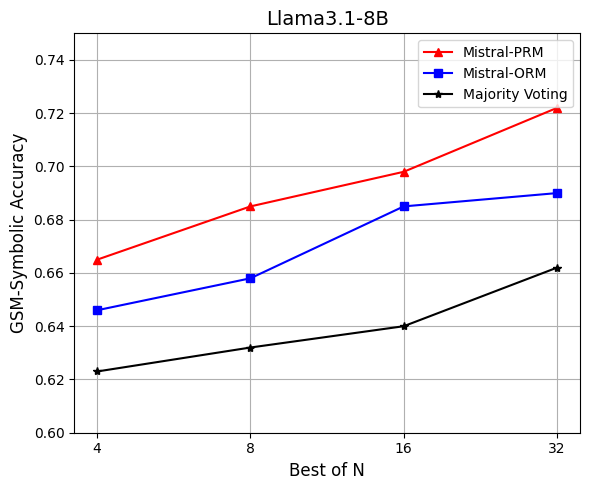

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
x = ["4", "8", "16", "32",]

mistral_prm = [0.665, 0.685, 0.698, 0.722]
mistral_orm = [0.646, 0.658, 0.685, 0.69]
majority_voting = [0.623, 0.632, 0.640, 0.662]


# Validate data lengths
if not all(len(lst) == len(x) for lst in [mistral_prm, majority_voting, mistral_orm_pairwise_bt, mistral_orm]):
    raise ValueError("Data lists must have the same length as the x-axis values.")

# Plotting
plt.figure(figsize=(6, 5))

plt.plot(range(len(x)), mistral_prm, marker='^', color='red', label='Mistral-PRM')
# plt.plot(range(len(x)), mistral_orm_pairwise_bt, marker='s', color='green', label='Mistral-ORM-Pairwise-BT')
plt.plot(range(len(x)), mistral_orm, marker='s', color='blue', label='Mistral-ORM')
plt.plot(range(len(x)), majority_voting, marker='*', color='black', label='Majority Voting')

# Customizing the plot
plt.xlabel('Best of N', fontsize=12)
plt.ylabel('GSM-Symbolic Accuracy', fontsize=12)
plt.title('Llama3.1-8B', fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.xticks(range(len(x)), x, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0.6, 0.75)

# Show plot
plt.tight_layout()
plt.show()


# Stop here

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q5_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. Gemma 6 trillion tokens is 2.5x faster! [free Colab](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>